In [13]:
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

from pycocotools.mask import decode, encode

import keras
from keras import backend as K

from keras.models import Sequential, Model
from keras.layers import Conv2DTranspose, ZeroPadding2D, UpSampling2D, Add, Reshape, BatchNormalization
from keras.layers.core import Dense, Activation, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D

from keras.losses import categorical_crossentropy

from keras.applications.vgg19 import VGG19

import cv2

from pycocotools.cocostuffeval import *
from pycocotools.cocostuffhelper import *

In [70]:
K.tensorflow_backend._get_available_gpus()

[]

# Data Preprocessing

In [2]:
annFile = 'annotations/stuff_val2017.json'
coco = COCO(annFile)

loading annotations into memory...
Done (t=2.08s)
creating index...
index created!


In [3]:
catIds = coco.getCatIds(catNms=['person', 'dog', 'skateboard'])
imgIds = coco.getImgIds(catIds=catIds)
imgIds = coco.getImgIds(imgIds = [324158])
img = coco.loadImgs(imgIds[np.random.randint(0, len(imgIds))])[0]

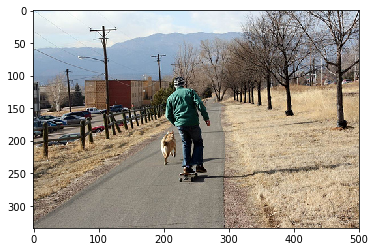

In [4]:
I = io.imread(img['coco_url'])
plt.imshow(I)
plt.show()

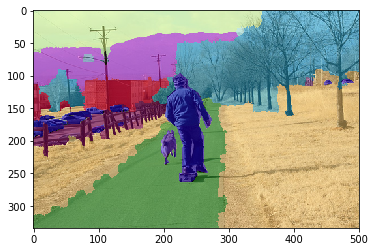

In [5]:
plt.imshow(I)
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

In [10]:
# 0, 124, 169
single_stuff = np.zeros_like(labelMap)
single_stuff[labelMap == 124] = 255
conc = np.zeros((334, 500, 3))
conc[:, :, 0] = single_stuff
conc[:, :, 1] = single_stuff
conc[:, :, 2] = single_stuff
plt.imshow(conc)

NameError: name 'labelMap' is not defined

In [52]:
def get_ground_truth(coco, imgId, num_classes=92, class_start_id=92):
    label_map = cocoSegmentationToSegmentationMap(coco, imgId, checkUniquePixelLabel=True)
    ground_truth = np.zeros((334, 500, num_classes))
    
    for i in range(num_classes):
        ground_truth[:, :, i][label_map == class_start_id + i] = 1
    return ground_truth

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


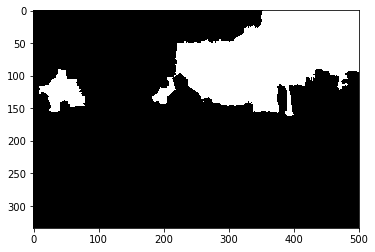

In [53]:
ground_truth = get_ground_truth(coco, 324158)
img = np.repeat(ground_truth[:, :, 77, np.newaxis], 3, axis=2)
img = img * 255
plt.imshow(img)

# Train model

In [1]:
def batch(directory, n=1):
    filenames = os.listdir(directory)
    l = len(filenames)
    
    for ndx in range(0, l, n):
        imgs = []
        batch_files = filenames[ndx:min(ndx + n, l)]
        for filename in batch_files:
            imgs.append(io.imread(os.path.join(directory, filename)))
            
        yield imgs

In [14]:
def gen_model():
    # output shape: (334, 500, 92)
    model = VGG19(include_top=False, input_shape=(334, 500, 3))    
    for layer in model.layers:
        layer.trainable = False
    
    out = Conv2DTranspose(512, (3, 3), strides=(2, 2), activation='relu', padding='same')(model.layers[-1].output)    
    out = BatchNormalization()(out)
    
    out = Conv2DTranspose(256, (3, 3), strides=(2, 2), activation='relu', padding='same')(out)
    out = ZeroPadding2D((0,1))(out)
    out = BatchNormalization()(out)

    out = Conv2DTranspose(128, (3, 3), strides=(2, 2), activation='relu', padding='same')(out)
    out = ZeroPadding2D((1,0))(out)
    out = BatchNormalization()(out)
    
    out = Conv2DTranspose(128, (3, 3), strides=(2, 2), activation='relu', padding='same')(out)
    out = ZeroPadding2D((1,1))(out)
    
    skip_connection = Conv2D(128, (3, 3), activation='relu', padding='same')(model.layers[0].output)    
   
    out = UpSampling2D((2,2))(out)
    out = ZeroPadding2D((1,0))(out)
    
    out = Add()([skip_connection, out])
    out = BatchNormalization()(out)
    
    out = Conv2D(92, (3, 3), activation='relu', padding='same')(out)
    
    seg_model = Model(inputs=model.inputs, outputs=[out])    
    return seg_model
    
gen_model()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 334, 500, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 334, 500, 64) 1792        input_11[0][0]                   
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 334, 500, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 167, 250, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

In [86]:
y = np.array([get_ground_truth(coco, 324158, num_classes=92, class_start_id=92)])

In [94]:
def pixelwise_crossentropy(y_true, y_pred):
    reshaped_output = Reshape((334*500, 92))(y_pred)
    new_output = Activation('softmax')(reshaped_output)
    return categorical_crossentropy(Reshape((334*500, 92))(y_true), new_output)

In [15]:
# TODO: Define loss function
def train_model(X, y):
    model = gen_model()
#     model.compile('adam', 'mse', ['mae'])
    model.compile(loss=pixelwise_crossentropy, optimizer='adam')
    
    model_path = 'model.h5'
    callbacks = [
    EarlyStopping(
        monitor='val_acc', 
        patience=10,
        mode='max',
        verbose=1),
    ModelCheckpoint(model_path,
        monitor='val_acc', 
        save_best_only=True, 
        mode='max',
        verbose=0)
    ]
    history = model.fit(X, y, epochs=200, batch_size=32, validation_split=0.0, shuffle=True, callbacks=callbacks)
#     model.save('model.h5')   
    return model

In [96]:
train_model(np.array([I]), y)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_41 (InputLayer)           (None, 334, 500, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 334, 500, 64) 1792        input_41[0][0]                   
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 334, 500, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 167, 250, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

1/1 [==============================] - 9s 9s/step - loss: 12.0851
Epoch 3/200


KeyboardInterrupt: 

# Evaluation

In [54]:
def convert_pred_to_label_map(pred, class_start_id=92):
    return class_start_id + np.argmax(pred, axis=2)

In [55]:
def evaluate(cocoGt):
    img = coco.loadImgs([324158])[0]
    I = io.imread(img['coco_url'])
    
    model = gen_model()    
    y = model.predict(np.array([I]))
    labelMap = convert_pred_to_label_map(y[0])
    
    anns = segmentationToCocoResult(labelMap, 324158, stuffStartId=92)   
    cocoRes = coco.loadRes(anns)
    coco_eval = COCOStuffeval(cocoGt, cocoRes)
    coco_eval.params.imgIds = [324158]
    coco_eval.evaluate()
    coco_eval.summarize()

In [56]:
evaluate(coco)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 334, 500, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 334, 500, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 334, 500, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 167, 250, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 167, 250, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 167, 250, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 83, 125, 128)      0         
__________